Differential condensability analysis and plots

In [1]:
# python modules
import sys
import copy
import re
import random
import pickle
import numpy as np
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import scipy
from scipy import stats

In [2]:
# custom modules
sys.path.append('/Users/sangwoopark/Projects/condense-seq/postpro_scripts')
import graphics_edit as graphics
import load_file_edit as load_file
import Interval_dict
import statis_edit as statis

In [3]:
# matplotlib setting
%matplotlib inline
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"

In [4]:
### parameters
cell_org = {'H1':'human',
            'GM':'human',
            'mCD8T:WT':'mouse',
            'mCD8T:DFMO':'mouse',
            'mCD8T:ODCKO':'mouse'}

cell_chrnames = {'H1':['chr%s' % (i) for i in range(1, 23)] + ['chrX', 'chrY'],
                 'GM':['chr%s' % (i) for i in range(1, 23)] + ['chrX'],
                 'mCD8T:WT':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:DFMO':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:ODCKO':['chr%s' % (i) for i in range(1, 20)] + ['chrX']}

In [5]:
def plot_score_scatter (ID_score1,
                        ID_score2,
                        ID_color,
                        IDs=None,
                        standardize_color=True,
                        ID_text={},
                        fig_width=None,
                        fig_height=None,
                        vmin=-5,
                        vmax=5,
                        alpha=0.3,
                        size=2,
                        draw_eqline=True,
                        xlim=[None,None],
                        ylim=[None,None],
                        xlabel='',
                        ylabel='',
                        title=None,
                        cbar_ylabel='',
                        save=False,
                        note=''):

    # custom diverging colormap with white background
    pastel_jet = LinearSegmentedColormap.from_list('white_viridis',
                                                   [(0, 'darkblue'),
                                                    (0.1, 'blue'),
                                                    (0.2, 'tab:blue'),
                                                    (0.4, 'tab:cyan'),
                                                    (0.5, 'ivory'),
                                                    (0.6, 'tab:orange'),
                                                    (0.8, 'tab:red'),
                                                    (0.9, 'red'),
                                                    (1, 'darkred')
                                                    ], N=256)

    all_IDs = set(ID_score1.keys()) & set(ID_score2.keys())

    if IDs == None:
        IDs = all_IDs
    else:
        IDs = all_IDs & set(IDs)

    out_IDs = IDs & set(ID_text.keys())
    IDs -= out_IDs

    IDs = sorted(list(IDs))
    out_IDs = sorted(list(out_IDs))
    
    X, Y = [], []
    C = []
    for ID in IDs:
        X.append(ID_score1[ID])
        Y.append(ID_score2[ID])
        C.append(ID_color[ID])

    if standardize_color:
        C = stats.zscore(C)

    # draw all genes
    if fig_width==None or fig_height==None:
        fig = plt.figure()
    else:
        fig = plt.figure(figsize=(fig_width,
                                  fig_height))
    
    plt.scatter(X,
                Y,
                c=C,
                cmap=pastel_jet,
                vmin=vmin,
                vmax=vmax,
                alpha=alpha,
                s=size)

    for ID in out_IDs:
        text = ID_text[ID]
        x, y = ID_score1[ID], ID_score2[ID]
        
        plt.plot(x,
                 y,
                 'kx',
                 markersize=6,
                 alpha=1,
                 zorder=10,
                 mew=2)
        
        plt.annotate(text,
                     (x+0.05, y+0.05),
                     color='black',
                     zorder=40,
                     size=10,
                     weight='bold')
        
    if draw_eqline:
        plt.plot([min(X), max(X)],
                 [min(Y), max(Y)],
                 'k--',
                 alpha=0.7)
    
    plt.xlim(xlim)
    plt.ylim(ylim)

    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel(ylabel, fontsize=13)

    if title!=None:
        plt.title(title, fontsize=15)

    cbar = plt.colorbar()
    cbar.ax.set_ylabel(cbar_ylabel,
                       rotation=-90,
                       va="bottom")

    if save:
        plt.savefig("score_scatter_%s.png" % (note),
                    bbox_inches='tight',
                    dpi=300)

    plt.tight_layout()
    plt.show()
    plt.close()


In [6]:
### set target chromosome
chr_choices = cell_chrnames['mCD8T:WT']

In [7]:
### read GTF file
GTF_path = '/Users/sangwoopark/jhu_rockfish/MouseEpigeneticData/GTF/'
GTF_fname = 'ENCFF871VGR.gtf'
geneID_field_value = load_file.read_GTF (GTF_path + GTF_fname,
                                         chr_list=cell_chrnames['mCD8T:WT'])

In [8]:
### get near TSS interval for each genes
chr_geneID_interval = {}
for geneID in geneID_field_value:
    try:
        chr = geneID_field_value[geneID]['chr']
        pos = geneID_field_value[geneID]['TSS']
    except:
        continue
    interval = (pos-2500, pos+2500)

    if chr not in chr_geneID_interval:
        chr_geneID_interval[chr] = {}
    chr_geneID_interval[chr][geneID] = interval

In [9]:
### set target gtab file
gtab_path = '/Users/sangwoopark/jhu_rockfish/2024_01_05_GEO/processed_files/'

dinfo_dkey = {'mCD8T:WT_NCP_sp_1rep_deep_chr(\d+|[XY])_score.gtab.gz':
              {'mCD8T:WT_NCP_sp_8_1rep_deep': (1, 'mCD8T:WT', 'score', 8)},
              'mCD8T:DFMO_NCP_sp_1rep_deep_chr(\d+|[XY])_score.gtab.gz':
              {'mCD8T:DFMO_NCP_sp_8_1rep_deep': (1, 'mCD8T:DFMO', 'score', 8)},
              'mCD8T:ODCKO_NCP_sp_1rep_deep_chr(\d+|[XY])_score.gtab.gz':
              {'mCD8T:ODCKO_NCP_sp_8_1rep_deep': (1, 'mCD8T:ODCKO', 'score', 8)}
              }

In [10]:
### load condense-seq data and get mean score near TSS of genes
dkey_geneID_mscore = {}
for fkey in dinfo_dkey:
    field_dkey = dinfo_dkey[fkey]

    if not field_dkey:
        field_choices = None
    else:
        field_choices = field_dkey.keys()

    for fname in glob.glob(gtab_path + '*'):
        if not re.match(fkey, fname.rsplit('/')[-1]):
            continue

        print "loading %s" % (fname.rsplit('/')[-1])

        field_chr_ID_value = load_file.read_gtab(fname,
                                                 mode='col',
                                                 field_choices=field_choices,
                                                 chr_choices=chr_choices,
                                                 skip_nan=True,
                                                 by_chr=True)

        for field, chr_ID_value in field_chr_ID_value.items():
            try:
                dkey = field_dkey[field]
            except:
                dkey = field

            for chr, ID_value in chr_ID_value.items():
                ID_loc = {}
                for ID in ID_value:
                    if len(ID) == 2:
                        ID_loc[ID] = ID[1]
                    else:
                        ID_loc[ID] = ID[1:]
                
                geneID_interval = chr_geneID_interval[chr]

                geneID_mscore = statis.bin_data_mean(geneID_interval,
                                                     ID_loc,
                                                     ID_value,
                                                     min_sample_size=10,
                                                     skip_nan=True,
                                                     silent=True)

                if dkey not in dkey_geneID_mscore:
                    dkey_geneID_mscore[dkey] = {}
                dkey_geneID_mscore[dkey].update(geneID_mscore)
                

loading mCD8T:WT_NCP_sp_1rep_deep_chr10_score.gtab.gz


loading mCD8T:WT_NCP_sp_1rep_deep_chr11_score.gtab.gz


loading mCD8T:WT_NCP_sp_1rep_deep_chr12_score.gtab.gz


loading mCD8T:WT_NCP_sp_1rep_deep_chr13_score.gtab.gz


loading mCD8T:WT_NCP_sp_1rep_deep_chr14_score.gtab.gz


loading mCD8T:WT_NCP_sp_1rep_deep_chr15_score.gtab.gz


loading mCD8T:WT_NCP_sp_1rep_deep_chr16_score.gtab.gz


loading mCD8T:WT_NCP_sp_1rep_deep_chr17_score.gtab.gz


loading mCD8T:WT_NCP_sp_1rep_deep_chr18_score.gtab.gz


loading mCD8T:WT_NCP_sp_1rep_deep_chr19_score.gtab.gz


loading mCD8T:WT_NCP_sp_1rep_deep_chr1_score.gtab.gz


loading mCD8T:WT_NCP_sp_1rep_deep_chr2_score.gtab.gz


loading mCD8T:WT_NCP_sp_1rep_deep_chr3_score.gtab.gz


loading mCD8T:WT_NCP_sp_1rep_deep_chr4_score.gtab.gz


loading mCD8T:WT_NCP_sp_1rep_deep_chr5_score.gtab.gz


loading mCD8T:WT_NCP_sp_1rep_deep_chr6_score.gtab.gz


loading mCD8T:WT_NCP_sp_1rep_deep_chr7_score.gtab.gz


loading mCD8T:WT_NCP_sp_1rep_deep_chr8_score.gtab.gz


loading mCD8T:WT_NCP_sp_1rep_deep_chr9_score.gtab.gz


loading mCD8T:WT_NCP_sp_1rep_deep_chrX_score.gtab.gz


loading mCD8T:DFMO_NCP_sp_1rep_deep_chr10_score.gtab.gz


loading mCD8T:DFMO_NCP_sp_1rep_deep_chr11_score.gtab.gz


loading mCD8T:DFMO_NCP_sp_1rep_deep_chr12_score.gtab.gz


loading mCD8T:DFMO_NCP_sp_1rep_deep_chr13_score.gtab.gz


loading mCD8T:DFMO_NCP_sp_1rep_deep_chr14_score.gtab.gz


loading mCD8T:DFMO_NCP_sp_1rep_deep_chr15_score.gtab.gz


loading mCD8T:DFMO_NCP_sp_1rep_deep_chr16_score.gtab.gz


loading mCD8T:DFMO_NCP_sp_1rep_deep_chr17_score.gtab.gz


loading mCD8T:DFMO_NCP_sp_1rep_deep_chr18_score.gtab.gz


loading mCD8T:DFMO_NCP_sp_1rep_deep_chr19_score.gtab.gz


loading mCD8T:DFMO_NCP_sp_1rep_deep_chr1_score.gtab.gz


loading mCD8T:DFMO_NCP_sp_1rep_deep_chr2_score.gtab.gz


loading mCD8T:DFMO_NCP_sp_1rep_deep_chr3_score.gtab.gz


loading mCD8T:DFMO_NCP_sp_1rep_deep_chr4_score.gtab.gz


loading mCD8T:DFMO_NCP_sp_1rep_deep_chr5_score.gtab.gz


loading mCD8T:DFMO_NCP_sp_1rep_deep_chr6_score.gtab.gz


loading mCD8T:DFMO_NCP_sp_1rep_deep_chr7_score.gtab.gz


loading mCD8T:DFMO_NCP_sp_1rep_deep_chr8_score.gtab.gz


loading mCD8T:DFMO_NCP_sp_1rep_deep_chr9_score.gtab.gz


loading mCD8T:DFMO_NCP_sp_1rep_deep_chrX_score.gtab.gz


loading mCD8T:ODCKO_NCP_sp_1rep_deep_chr10_score.gtab.gz


loading mCD8T:ODCKO_NCP_sp_1rep_deep_chr11_score.gtab.gz


loading mCD8T:ODCKO_NCP_sp_1rep_deep_chr12_score.gtab.gz


loading mCD8T:ODCKO_NCP_sp_1rep_deep_chr13_score.gtab.gz


loading mCD8T:ODCKO_NCP_sp_1rep_deep_chr14_score.gtab.gz


loading mCD8T:ODCKO_NCP_sp_1rep_deep_chr15_score.gtab.gz


loading mCD8T:ODCKO_NCP_sp_1rep_deep_chr16_score.gtab.gz


loading mCD8T:ODCKO_NCP_sp_1rep_deep_chr17_score.gtab.gz


loading mCD8T:ODCKO_NCP_sp_1rep_deep_chr18_score.gtab.gz


loading mCD8T:ODCKO_NCP_sp_1rep_deep_chr19_score.gtab.gz


loading mCD8T:ODCKO_NCP_sp_1rep_deep_chr1_score.gtab.gz


loading mCD8T:ODCKO_NCP_sp_1rep_deep_chr2_score.gtab.gz


loading mCD8T:ODCKO_NCP_sp_1rep_deep_chr3_score.gtab.gz


loading mCD8T:ODCKO_NCP_sp_1rep_deep_chr4_score.gtab.gz


loading mCD8T:ODCKO_NCP_sp_1rep_deep_chr5_score.gtab.gz


loading mCD8T:ODCKO_NCP_sp_1rep_deep_chr6_score.gtab.gz


loading mCD8T:ODCKO_NCP_sp_1rep_deep_chr7_score.gtab.gz


loading mCD8T:ODCKO_NCP_sp_1rep_deep_chr8_score.gtab.gz


loading mCD8T:ODCKO_NCP_sp_1rep_deep_chr9_score.gtab.gz


loading mCD8T:ODCKO_NCP_sp_1rep_deep_chrX_score.gtab.gz


In [11]:
### save the data as pickle
fname = './data/' + 'mCD8T_geneID_mscore'
pickle.dump(dkey_geneID_mscore, open(fname + ".pickle", "wb"))

In [12]:
### read RNA-seq data and compute FPKM
RNAseq_path = '/Users/sangwoopark/jhu_rockfish/MouseEpigeneticData/ODC_mouse_RNAseq/30-916504364/hit-counts/'

rep_cell_RNAseq_fname = {1:{'mCD8T:WT':'WT-1.counts.txt',
                            'mCD8T:DFMO':'I-1.counts.txt',
                            'mCD8T:ODCKO':'KO-1.counts.txt'},
                         2:{'mCD8T:WT':'WT-2.counts.txt',
                            'mCD8T:DFMO':'I-2.counts.txt',
                            'mCD8T:ODCKO':'KO-2.counts.txt'},
                         3:{'mCD8T:WT':'WT-3.counts.txt',
                            'mCD8T:DFMO':'I-3.counts.txt',
                            'mCD8T:ODCKO':'KO-3.counts.txt'}}

## compute exon lengths
geneID_exonlen = {}
for geneID in geneID_field_value:
    exons = geneID_field_value[geneID]['exons']
    length = 0
    for start, end in exons:
        length +=  end - start + 1
    geneID_exonlen[geneID] = length

## read read counts
cell_geneID_FPKMs = {}
for rep in sorted(rep_cell_RNAseq_fname):
    cell_RNAseq_fname = rep_cell_RNAseq_fname[rep]
    for cell in sorted(cell_RNAseq_fname):
        RNAseq_fname = cell_RNAseq_fname[cell]
        field = RNAseq_fname.split('.')[0]

        ## get read counts
        geneID_count = load_file.read_tabular_file (RNAseq_path + RNAseq_fname,
                                                    mode="col")[field]

        total_count = 0
        for geneID in geneID_count:
            count = geneID_count[geneID]
            #if count <=0:
            #    continue
            geneID_count[geneID] +=1 # add pseudocount
            total_count += geneID_count[geneID]

        ## compute FPKM
        #geneID_FPKM = {}
        for geneID in geneID_count:
            try:
                FPM = (float(geneID_count[geneID]) / total_count)*(10**6)
                FPKM = float(FPM)/(geneID_exonlen[geneID]/1000.0)
            except:
                continue
            #geneID_FPKM[geneID] = FPKM

            if cell not in cell_geneID_FPKMs:
                cell_geneID_FPKMs[cell] = {}
            if geneID not in cell_geneID_FPKMs[cell]:
                cell_geneID_FPKMs[cell][geneID] = []
            cell_geneID_FPKMs[cell][geneID].append(FPKM)
            #cell_geneID_FPKMs[cell][geneID].append(geneID_count[geneID])

In [13]:
### define common geneIDs
dkeys = [(1, 'mCD8T:WT', 'score', 8),
         (1, 'mCD8T:DFMO', 'score', 8),
         (1, 'mCD8T:ODCKO', 'score', 8)]
target_geneIDs = set([])         
for i in range(len(dkeys)):
    dkey = dkeys[i]
    geneID_mscore = dkey_geneID_mscore[dkey]
    geneIDs = set(geneID_mscore.keys())
    if i == 0:
        target_geneIDs |= geneIDs
        continue
    target_geneIDs &= geneIDs
target_geneIDs = sorted(list(target_geneIDs))
print 'Total gene count:' + str(len(target_geneIDs))

Total gene count:53831


In [14]:
### standardize the condensability scores
dkey_geneID_zscore = {}
for dkey in dkeys:
    geneID_mscore = dkey_geneID_mscore[dkey]
    geneID_zscore = statis.standardize_dict(geneID_mscore,
                                            keys=target_geneIDs)
    dkey_geneID_zscore[dkey] = geneID_zscore

In [ ]:
### plot condensability with gene expression differences
for i in range(len(dkey)-1):
    for j in range(i+1, len(dkeys)):
        dkey1 = dkeys[i]
        dkey2 = dkeys[j]
        
        geneID_zscore1 = dkey_geneID_zscore[dkey1]
        geneID_zscore2 = dkey_geneID_zscore[dkey2]

        cell1 = dkey1[1]
        cell2 = dkey2[1]
        
        ## compute gene expression differences
        geneID_dlogFPKM = {}
        for geneID in target_geneIDs:
            try:
                FPKM1 = np.nanmean(cell_geneID_FPKMs[cell1][geneID])
                FPKM2 = np.nanmean(cell_geneID_FPKMs[cell2][geneID])
            except:
                continue
            dlogFPKM = np.log2(1+FPKM2) - np.log2(1+FPKM1)
            geneID_dlogFPKM[geneID] = dlogFPKM

        
        ## plot scatter plot
        #plot_score_scatter (geneID_zscore1,
        #                    geneID_zscore2,
        #                    geneID_dlogFPKM,
        #                    IDs=list(set(target_geneIDs) & set(geneID_dlogFPKM.keys())),
        #                    standardize_color=True,
        #                    #ID_text=geneID_text,
        #                    fig_width=7.8,
        #                    fig_height=6,
        #                    vmin=-3,
        #                    vmax=3,
        #                    alpha=0.3,
        #                    size=2,
        #                    xlim=[None, None],
        #                    ylim=[None, None],
        #                    xlabel='%s (z-score)' % (cell1),
        #                    ylabel='%s (z-score)' % (cell2),
        #                    title='Condensability near TSS (5kb)',
        #                    cbar_ylabel='$\\Delta$ logFPKM (%s - %s)' % (cell2, cell1),
        #                    save=False,
        #                    note='%svs%s' % (cell1, cell2))
        print

In [16]:
### compute delta z score compared to WT
dkey0 = (1, 'mCD8T:WT', 'score', 8)
dkey1 = (1, 'mCD8T:DFMO', 'score', 8)
dkey2 = (1, 'mCD8T:ODCKO', 'score', 8)

geneID_dzscore1 = {}
geneID_dzscore2 = {}

for geneID in target_geneIDs:
    dzscore1 = dkey_geneID_zscore[dkey1][geneID] - dkey_geneID_zscore[dkey0][geneID]
    dzscore2 = dkey_geneID_zscore[dkey2][geneID] - dkey_geneID_zscore[dkey0][geneID]
    geneID_dzscore1[geneID] = dzscore1
    geneID_dzscore2[geneID] = dzscore2


Spearman correlation
0.5905226027023683



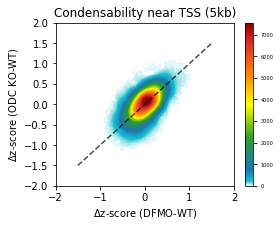

In [17]:
### plot dzscore vs dzscore plot [Extended Data Fig.10j]
X, Y = [], []
for geneID in target_geneIDs:
    X.append(geneID_dzscore1[geneID])
    Y.append(geneID_dzscore2[geneID])

print
print "Spearman correlation"
print statis.get_spearman_corr(X, Y)
print

fig = plt.figure(figsize=(4,3))
graphics.density_scatter(X, Y,
                         ax=plt.gca())
plt.plot([-1.5, 1.5], [-1.5, 1.5], 'k--', ms=2, alpha=0.7)
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.xlabel("$\Delta$z-score (DFMO-WT)", fontsize=10)
plt.ylabel("$\Delta$z-score (ODC KO-WT)", fontsize=10)
plt.title("Condensability near TSS (5kb)", fontsize=12)
plt.savefig("zdscoreVSzdscore.png", dpi=500, bbox_inches='tight')
plt.show()
plt.close()

In [18]:
### save dzscore as rnk file (by Ensemble ID)
dzscore_geneID1 = [(dzscore, geneID) for geneID, dzscore in geneID_dzscore1.items()]
dzscore_geneID1 = sorted(dzscore_geneID1, reverse=True)
dzscore_geneID2 = [(dzscore, geneID) for geneID, dzscore in geneID_dzscore2.items()]
dzscore_geneID2 = sorted(dzscore_geneID2, reverse=True)
fname1 = './data/mCD8T_DFMOvsWT_geneID.rnk'
fname2 = './data/mCD8T_ODCKOvsWT_geneID.rnk'

for fname, dzscore_geneID in zip([fname1, fname2],
                                 [dzscore_geneID1, dzscore_geneID2]):
    f = open(fname, 'w')
    for dzscore, geneID in dzscore_geneID:
        print >> f, '%s\t%f' % (geneID, dzscore)
    f.close()

In [19]:
### reorganize dzscores by gene name
gname_dzscores1 = {}
for geneID, dzscore in geneID_dzscore1.items():
    try:
        gname = geneID_field_value[geneID]['geneName']
    except:
        continue
    if gname not in gname_dzscores1:
        gname_dzscores1[gname] = []
    gname_dzscores1[gname].append(dzscore)
    
gname_dzscores2 = {}
for geneID, dzscore in geneID_dzscore2.items():
    try:
        gname = geneID_field_value[geneID]['geneName']
    except:
        continue
    if gname not in gname_dzscores2:
        gname_dzscores2[gname] = []
    gname_dzscores2[gname].append(dzscore)

In [20]:
### save dzscore as rnk file (by gene name)
dzscore_gname1 = [(np.mean(dzscores), gname) for gname, dzscores in gname_dzscores1.items()]
dzscore_gname1 = sorted(dzscore_gname1, reverse=True)
dzscore_gname2 = [(np.mean(dzscores), gname) for gname, dzscores in gname_dzscores2.items()]
dzscore_gname2 = sorted(dzscore_gname2, reverse=True)
fname1 = './data/mCD8T_DFMOvsWT_gname.rnk'
fname2 = './data/mCD8T_ODCKOvsWT_gname.rnk'

for fname, dzscore_gname in zip([fname1, fname2],
                                [dzscore_gname1, dzscore_gname2]):
    f = open(fname, 'w')
    for dzscore, gname in dzscore_gname:
        print >> f, '%s\t%f' % (gname, dzscore)
    f.close()